In [1]:
import sympy as sp
from sympy import *
import scipy.optimize as optimize
import numpy as np
from matplotlib import pyplot as plt
from casadi import *
from sympy import diff as smdiff
import sys

In [2]:
def D1(p1, params):
    t1, t2, ε1, ε2, c, κ1, κ2 = params
    return κ1*p1**(-ε1)

def D2(p2, params):
    t1, t2, ε1, ε2, c, κ1, κ2 = params
    return κ2*p2**(-ε2)


def τ1(p1, p2, params):
    t1, t2, ε1, ε2, c, κ1, κ2 = params
    return p1*D1(p1, params)/(p1*D1(p1, params)+p2*D2(p2, params))*t1

def τ2(p1, p2, params):
    t1, t2, ε1, ε2, c, κ1, κ2 = params
    return p2*D2(p2, params)/(p1*D1(p1, params)+p2*D2(p2, params))*t2

def π1(p1, params):
    t1, t2, ε1, ε2, c, κ1, κ2 = params
    return (p1-c)*D1(p1, params)

def π2(p2, params):
    t1, t2, ε1, ε2, c, κ1, κ2 = params
    return (p2-c)*D2(p2, params)


def π(p1, p2, params):
    return (1-τ1(p1, p2, params)-τ2(p1, p2, params))*(π1(p1, params)+π2(p2, params))

def π_to_minimize(p, params):
    p1, p2 = p
    return -1*π(p1, p2, params)



In [4]:
def max_π_casadi(params, x0_vals):

    p1 = SX.sym("p1")
    p2 = SX.sym("p2")

    x = vertcat(p1, p2)
    obj = -π(p1, p2, params)

    x0 = DM(x0_vals)

    nlp = {
        "x": x,
        "f": obj,
    }

    print_opt_diagnostics = False
    if print_opt_diagnostics:
        ipopt_print_level = 3
    else:
        ipopt_print_level = 0

    solver = nlpsol("solver", "ipopt", nlp, {
                    "ipopt.print_level": ipopt_print_level, "ipopt.tol": 1e-10, 'print_time': 0})
    solution = solver(
        x0=x0,
    )

    return np.array(solution["x"])

def do_opt(approach, params, x0_vals):
    if approach == "casadi":
        return max_π_casadi(params, x0_vals)
    elif approach == "scipy":
        return optimize.minimize(π_to_minimize, x0_vals, args=(params), method='Nelder-Mead', tol=1e-10).x
    else:
        raise ValueError("approach must be 'casadi' or 'scipy'")


In [43]:
t1, t2, ε1, ε2, c, κ1, κ2 = 0, 0.2,6,6,0.49,1,1
t1_set = np.linspace(0,0.4,51)
p1_set = []
p2_set = []
q1_set = []
q2_set = []
r1_set = []
r2_set = []
π1_set = []
π2_set = []
params = [t1, t2, ε1, ε2, c, κ1, κ2]
for i in t1_set:
    params[0] = i
    opt = do_opt("casadi", params, [1, 1])
    p1_opt, p2_opt = opt
    p1_set.append(p1_opt)
    p2_set.append(p2_opt)
    q1_set.append(D1(p1_opt, params))
    q2_set.append(D2(p2_opt, params))
    r1_set.append(D1(p1_opt, params)*p1_opt)
    r2_set.append(D2(p2_opt, params)*p2_opt)
    π1_set.append((1-τ1(p1_opt, p2_opt, params)-τ2(p1_opt, p2_opt, params))*(π1(p1_opt, params)))
    π2_set.append((1-τ1(p1_opt, p2_opt, params)-τ2(p1_opt, p2_opt, params))*(π2(p2_opt, params)))

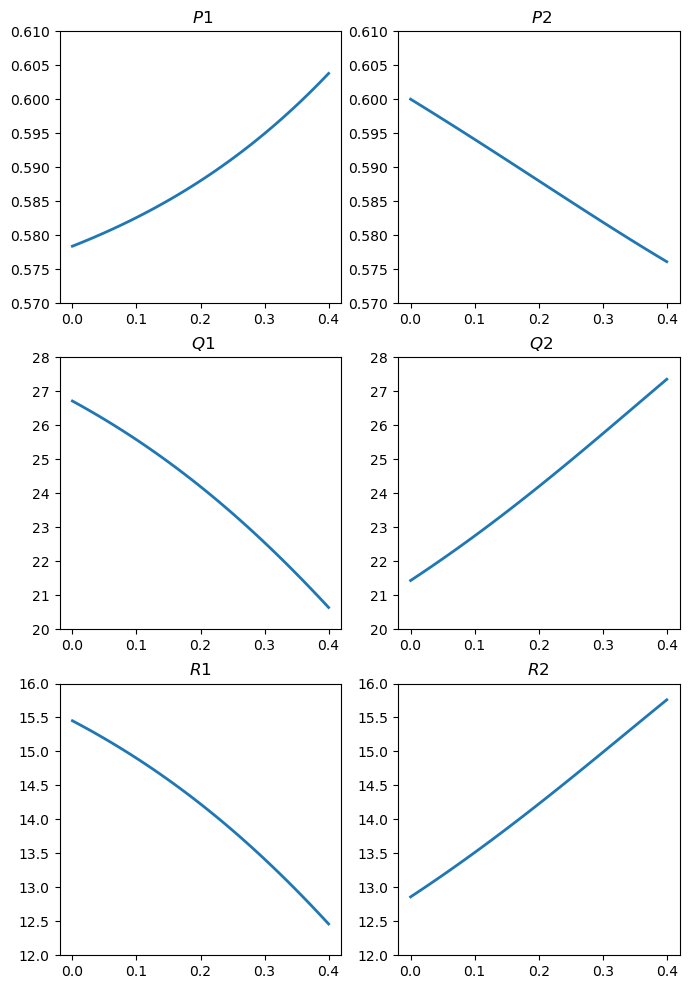

In [51]:
fig, ax = plt.subplots(3,2, figsize=(8, 12))
ax[0,0].plot(t1_set, p1_set, linewidth=2)
ax[0,0].set(title=' $P1$')
ax[0,0].set_ylim([0.57,0.61])

ax[0,1].plot(t1_set, p2_set , linewidth=2)
ax[0,1].set(title=' $P2$')
ax[0,1].set_ylim([0.57,0.61])

ax[1,0].plot(t1_set, q1_set , linewidth=2)
ax[1,0].set(title=' $Q1$')
ax[1,0].set_ylim([20,28])

ax[1,1].plot(t1_set, q2_set, linewidth=2)
ax[1,1].set(title=' $Q2$')
ax[1,1].set_ylim([20,28])

ax[2,0].plot(t1_set, r1_set, linewidth=2)
ax[2,0].set(title= '$R1$')
ax[2,0].set_ylim([12,16])

ax[2,1].plot(t1_set, r2_set, linewidth=2)
ax[2,1].set(title= '$R2$')
ax[2,1].set_ylim([12,16])

#ax[0,3].plot(t1_set, π1_set, linewidth=2)
#ax[0,3].set(title= '$π1$')

#ax[1,3].plot(t1_set, π2_set, linewidth=2)
#ax[1,3].set(title= '$π2$')

plt.savefig("fig_varyt1.eps")

plt.show()